# Cain's Jawbone

introduction, murder mystery blabla, took this opportunity to try out graph algorithms to help in this puzzle

## Book as a Graph?

tfidf vectors, cosine similarity, fully connected

In [1]:
import networkx as nx
import numpy as np

from nltk import word_tokenize, pos_tag, download
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# download relevant nltk datasets
datasets = ["wordnet", "omw-1.4", "punkt", "averaged_perceptron_tagger", "stopwords"]
for dataset in datasets:
    download(dataset)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\maxst\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\maxst\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\maxst\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\maxst\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\maxst\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


preprocessing...

In [2]:
stop_words = set(stopwords.words("english"))

def to_wordnet(tag: str) -> str | None:
    """Converts between position tags and wordnet tags for lemmatization"""
    match tag[0]:
        case "J":
            return wordnet.ADJ
        case "R":
            return wordnet.ADV
        case "N":
            return wordnet.NOUN
        case "V":
            return wordnet.VERB
        case _:
            return None


def preprocess(text: str) -> str:
    """Tokenizes and lemmatizes the text"""
    tokens = [token for token in word_tokenize(text.lower())]
    cleaned = [token for token in tokens if len(token) > 1 and token[0].isalnum() and token[-1].isalnum()]
    tagged = [(word, to_wordnet(tag)) for word, tag in pos_tag(cleaned) if len(word) > 1]
    lemmatizer = WordNetLemmatizer()
    lemmatized = [
        lemmatizer.lemmatize(word, pos=tag) for (word, tag) in tagged if tag is not None
    ]
    words = [word for word in lemmatized if word not in stop_words]
    return " ".join(words)

In [3]:
# load Cain's Jawbone book
with open("books/Cain's Jawbone.txt", "r", encoding="utf-8") as book:
    pages = book.read().split("\n\n")

data = [preprocess(page) for page in pages]

edge weighting using cosine similarity of tfs...

In [4]:
# vectorize tokens to frequencies
vectorizer = TfidfVectorizer(use_idf=False)
freqs = vectorizer.fit_transform(data)

# calculate cosine similarities between pages
num_pages = len(data)
weights = np.zeros((num_pages, num_pages))
for i, j in np.ndindex(weights.shape):
    weights[i, j] = cosine_similarity(freqs.getrow(i), freqs.getrow(j)).flatten()[0]

# generate fully connected, weighted graph
graph = nx.complete_graph(num_pages)
for i, j in graph.edges:
    graph.edges[i, j]["weight"] = weights[i, j]

explain plot below:

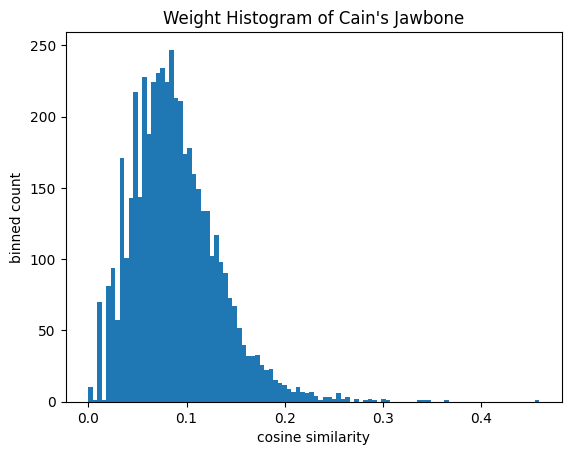

minimum 0.000
average 0.089 +- 0.0439
maximum 0.459


In [5]:
from matplotlib import pyplot as plt

stats = np.array([graph.edges[edge]["weight"] for edge in graph.edges])

plt.hist(stats, bins=100)
plt.xlabel("cosine similarity")
plt.ylabel("binned count")
plt.title("Weight Histogram of Cain's Jawbone")
plt.show()

print(f"minimum {stats.min():5.3f}")
print(f"average {stats.mean():5.3f} +- {stats.std():5.3}")
print(f"maximum {stats.max():5.3f}")

## Traversal?

greedy not feasable, naive: where to start, not meaningful since there can be different narratives, maybe TSP solver but not cyclic, GNN too complicated for this project but here are some possible architectures

In [6]:
# TODO: do naive or some other traversal to showcase problems

## Clustering

know about 6 murders so extract the 6 narratives around them (theorized) to decrease search space using clustering algorithms / community detection

### Louvain Algorithm

explain algorithm

can use resolution parameter to get the desired number of communities

In [7]:
# TODO: implement the louvain algorithm
louvain_algorithm = nx.community.louvain_communities

In [8]:
resolution = 1.05

runs = []
for seed in range(100):
    communities = louvain_algorithm(graph, resolution=resolution, seed=seed)
    runs.append(len(communities))
runs = np.array(runs)

print("number of communities")
print(f"minimum {runs.min()}")
print(f"average {runs.mean():.2f} +- {runs.std():.2f}")
print(f"maximum {runs.max()}")

number of communities
minimum 5
average 6.08 +- 0.67
maximum 8


### Spectral Clustering

explain...

In [9]:
# TODO: implement spectral clustering
from sklearn.cluster import SpectralClustering


def spectral_clustering(
    graph: nx.Graph, num_clusters: int, weight: str = "weight", seed: int | None = None
):
    adj_matrix = nx.adjacency_matrix(graph, weight=weight).todense()
    clusterer = SpectralClustering(
        n_clusters=num_clusters,
        affinity="precomputed",
        assign_labels="kmeans",
        random_state=seed,
    )
    return clusterer.fit_predict(adj_matrix)

## Comparison

how to compare? qualitatively need good knowledge of book, what quantitative measure? coherence?

### Quantitative Analysis

explain coherence

In [10]:
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel

texts = [page.split() for page in data]
book_dictionary = Dictionary(vectorizer.inverse_transform(freqs))

def coherence(groups: list[set[int]]) -> float:
    """Returns coherence measure for given groupings"""

    topics = []
    for group in groups:
        words = set()
        for node in group:
            words.update(data[node].split())
        topics.append(list(words))

    model = CoherenceModel(
        topics=topics,
        texts=texts,
        dictionary=book_dictionary,
        coherence="c_v",
    )

    return model.get_coherence()

In [11]:
from tqdm import trange

resolution = 1.05
num_clusters = 6
num_runs = 100
min_length = 5
seed_mod = 0

scores_louvain = []
scores_spectral = []
for seed in trange(num_runs):
    groups_louvain = []
    while len(groups_louvain) != num_clusters or np.any(
        [len(group) < min_length for group in groups_louvain]
    ):
        groups_louvain = louvain_algorithm(
            graph, resolution=resolution, seed=seed + seed_mod
        )
        seed_mod += 1
    scores_louvain.append(coherence(groups_louvain))
    if scores_louvain[-1] == max(scores_louvain):
        best_louvain = groups_louvain

    labels = spectral_clustering(graph, num_clusters, seed=seed)
    groups_spectral = [
        set([node for node in graph if labels[node] == i]) for i in range(num_clusters)
    ]
    scores_spectral.append(coherence(groups_spectral))
    if scores_spectral[-1] == max(scores_spectral):
        best_spectral = groups_spectral

scores_louvain = np.array(scores_louvain)
scores_spectral = np.array(scores_spectral)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [32:03<00:00, 19.23s/it]


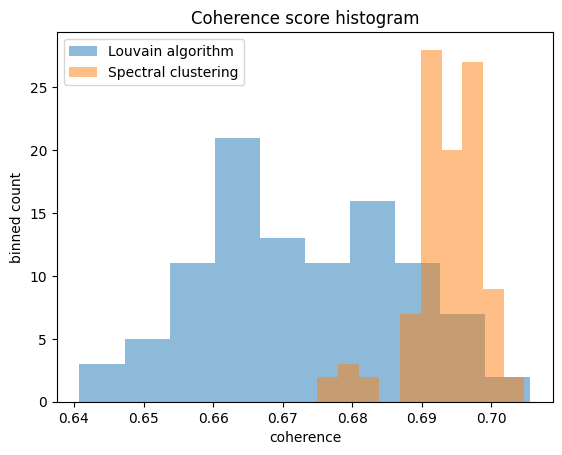

           min    mean +- std     max  
louvain  [0.641, 0.673 +- 0.014, 0.706]
spectral [0.675, 0.693 +- 0.005, 0.705]


In [12]:
bins = 10
plt.hist(scores_louvain, bins=bins, alpha=0.5, label="Louvain algorithm")
plt.hist(scores_spectral, bins=bins, alpha=0.5, label="Spectral clustering")
plt.xlabel("coherence")
plt.ylabel("binned count")
plt.title("Coherence score histogram")
plt.legend()
plt.show()

print("           min    mean +- std     max  ")
print(f"louvain  [{scores_louvain.min():.3f}, {scores_louvain.mean():.3f} +- {scores_louvain.std():.3f}, {scores_louvain.max():.3f}]")
print(f"spectral [{scores_spectral.min():.3f}, {scores_spectral.mean():.3f} +- {scores_spectral.std():.3f}, {scores_spectral.max():.3f}]")

plot the clusterings with the best coherence

In [13]:
from netgraph import Graph
import matplotlib as mpl


def plot_groups(
    graph: nx.Graph, groups: list[set[int]], title: str | None = None
) -> None:
    """Plot the communities of a graph."""
    groups_dict = {
        node: i for (i, group) in enumerate(groups) for node in group
    }
    colors = mpl.colormaps["tab10"].colors[: len(groups)]
    node_color = {node: colors[i] for node, i in groups_dict.items()}
    max_weight = np.array([graph.edges[edge]["weight"] for edge in graph.edges]).max()
    edge_dict = {(i, j): graph.edges[(i, j)]["weight"] / max_weight for (i, j) in graph.edges}

    Graph(
        graph,
        node_color=node_color,
        node_edge_width=0,
        edge_alpha=edge_dict,
        edge_width=edge_dict,
        node_layout="community",
        node_layout_kwargs=dict(node_to_community=groups_dict),
        node_labels=True,
    )
    if title is not None:
        plt.title(title)
    plt.show()

c:\Users\maxst\Repos\Graph-Algorithms-Project\.venv\Lib\site-packages\netgraph\_node_layout.py:1023: RuntimeWarning: invalid value encountered in divide
  directions = deltas / magnitudes[:, np.newaxis]
c:\Users\maxst\Repos\Graph-Algorithms-Project\.venv\Lib\site-packages\netgraph\_utils.py:360: RuntimeWarning: invalid value encountered in divide
  v = v / np.linalg.norm(v, axis=-1)[:, None] # unit vector


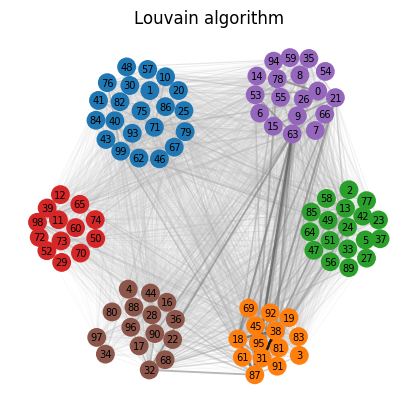

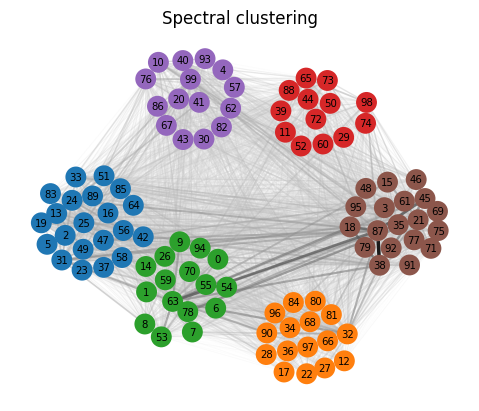

In [14]:
plot_groups(graph, best_louvain, title="Louvain algorithm")
plot_groups(graph, best_spectral, title="Spectral clustering")

In [16]:
permutations = np.math.factorial(num_clusters) * np.sum(list(map(np.math.factorial, map(len, best_louvain))))
print(f"number of permutations (louvain): {permutations:.2e}")

permutations = np.math.factorial(num_clusters) * np.sum(list(map(np.math.factorial, map(len, best_spectral))))
print(f"number of permutations (spectral): {permutations:.2e}")

number of permutations (louvain): 8.09e+23
number of permutations (spectral): 3.69e+22


explain search space reduction: 10^158 -> 10^22 or 10^23

## Sources

- [Fast unfolding of communities in large networks](https://arxiv.org/abs/0803.0476)
- [From Louvain to Leiden: guaranteeing well-connected communities](https://arxiv.org/abs/1810.08473)
- [A Tutorial on Spectral Clustering](https://arxiv.org/abs/0711.0189)
- [On Spectral Clustering: Analysis and an Algorithm](https://proceedings.neurips.cc/paper/2001/file/801272ee79cfde7fa5960571fee36b9b-Paper.pdf)
- [A Gentle Introduction to Graph Neural Networks](https://distill.pub/2021/gnn-intro/)
- [A Gentle Introduction to Deep Learning for Graphs](https://arxiv.org/abs/1912.12693)
- [Attention, Learn to Solve Routing Problems!](https://arxiv.org/abs/1803.08475)
- [Learning the Travelling Salesperson Problem Requires Rethinking Generalization](https://arxiv.org/abs/2006.07054)